# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=5,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-46-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5131 | MulticlassF1Score=0.0962
Batch-30 : CrossEntropyLoss=2.4682 | MulticlassF1Score=0.1806
Batch-45 : CrossEntropyLoss=2.4627 | MulticlassF1Score=0.2397
Batch-60 : CrossEntropyLoss=2.4352 | MulticlassF1Score=0.2730
Batch-75 : CrossEntropyLoss=2.3943 | MulticlassF1Score=0.3198
Batch-90 : CrossEntropyLoss=2.3701 | MulticlassF1Score=0.3571
Batch-105: CrossEntropyLoss=2.3729 | MulticlassF1Score=0.3851
Batch-120: CrossEntropyLoss=2.3693 | MulticlassF1Score=0.4090
Batch-135: CrossEntropyLoss=2.3748 | MulticlassF1Score=0.4314
Batch-150: CrossEntropyLoss=2.3568 | MulticlassF1Score=0.4530
Batch-165: CrossEntropyLoss=2.3454 | MulticlassF1Score=0.4733
Batch-180: CrossEntropyLoss=2.3247 | MulticlassF1Score=0.4912
Batch-195: CrossEntropyLoss=2.3558 | MulticlassF1Score=0.5079
Batch-210: CrossEntropyLoss=2.3343 | MulticlassF1Score=0.5226
Batch-225: CrossEntropyLoss=2.3316 | MulticlassF1Score=0.5367
Batch-226: CrossEntropyLoss=2.3433 | MulticlassF1Score=0.5374

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3285 | MulticlassF1Score=0.7635
Batch-30 : CrossEntropyLoss=2.3284 | MulticlassF1Score=0.7601
Batch-45 : CrossEntropyLoss=2.3292 | MulticlassF1Score=0.7604
Batch-60 : CrossEntropyLoss=2.3363 | MulticlassF1Score=0.7584
Batch-63 : CrossEntropyLoss=2.3305 | MulticlassF1Score=0.7581

Training   : Mean CrossEntropyLoss = 2.4045 | Mean MulticlassF1Score = 0.3645
Validation : Mean CrossEntropyLoss = 2.3262 | Mean MulticlassF1Score = 0.7612

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3224 | MulticlassF1Score=0.7638
Batch-30 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7676
Batch-45 : CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7758
Batch-60 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.7768
Batch-75 : CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7783
Batch-90 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7798
Batch-105: CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7795
Batch-120: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7816
Batch-135: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7834
Batch-150: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.7851
Batch-165: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7855
Batch-180: CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7864
Batch-195: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7877
Batch-210: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7890
Batch-225: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7898
Batch-226: CrossEntropyLoss=2.3191 | MulticlassF1Score=0.7897

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3185 | MulticlassF1Score=0.7992
Batch-30 : CrossEntropyLoss=2.3166 | MulticlassF1Score=0.8000
Batch-45 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8010
Batch-60 : CrossEntropyLoss=2.3167 | MulticlassF1Score=0.8017
Batch-63 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8016

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3142 | Mean MulticlassF1Score = 0.7794
Validation : Mean CrossEntropyLoss = 2.3097 | Mean MulticlassF1Score = 0.7995

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8076
Batch-30 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8073
Batch-45 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.8049
Batch-60 : CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8032
Batch-75 : CrossEntropyLoss=2.3197 | MulticlassF1Score=0.8044
Batch-90 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8045
Batch-105: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8051
Batch-120: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8050
Batch-135: CrossEntropyLoss=2.3161 | MulticlassF1Score=0.8053
Batch-150: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.8047
Batch-165: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.8049
Batch-180: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8064
Batch-195: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8077
Batch-210: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8087
Batch-225: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8093
Batch-226: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8093

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8245
Batch-30 : CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8236
Batch-45 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8242
Batch-60 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8237
Batch-63 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8235

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3073 | Mean MulticlassF1Score = 0.8057
Validation : Mean CrossEntropyLoss = 2.3030 | Mean MulticlassF1Score = 0.8243

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8227
Batch-30 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8274
Batch-45 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8281
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8285
Batch-75 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8279
Batch-90 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8281
Batch-105: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8279
Batch-120: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8281
Batch-135: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8275
Batch-150: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8269
Batch-165: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8269
Batch-180: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8271
Batch-195: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8264
Batch-210: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8270
Batch-225: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8273
Batch-226: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8274

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8209
Batch-30 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8259
Batch-45 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8260
Batch-60 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8265
Batch-63 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8273
Validation : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8252

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8310
Batch-30 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8323
Batch-45 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8310
Batch-60 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8318
Batch-75 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8320
Batch-90 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8319
Batch-105: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8306
Batch-120: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8309
Batch-135: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8306
Batch-150: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8301
Batch-165: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8300
Batch-180: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8301
Batch-195: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8301
Batch-210: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8303
Batch-225: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8299
Batch-226: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8300

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8223
Batch-30 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8236
Batch-45 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8273
Batch-60 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8285
Batch-63 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8307
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8251

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8280
Batch-30 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8314
Batch-45 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8308
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8318
Batch-75 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8327
Batch-90 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8334
Batch-105: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8325
Batch-120: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8327
Batch-135: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8323
Batch-150: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8320
Batch-165: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8321
Batch-180: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8323
Batch-195: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8327
Batch-210: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8336
Batch-225: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8346
Batch-226: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8347

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8485
Batch-30 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8442
Batch-45 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8447
Batch-60 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8430
Batch-63 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8439

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8323
Validation : Mean CrossEntropyLoss = 2.2965 | Mean MulticlassF1Score = 0.8448

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8446
Batch-30 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8474
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8499
Batch-60 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8501
Batch-75 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8511
Batch-90 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8502
Batch-105: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8523
Batch-120: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8552
Batch-135: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8574
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8590
Batch-165: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8606
Batch-180: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8617
Batch-195: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8630
Batch-210: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8639
Batch-225: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8648
Batch-226: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8648

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8738
Batch-30 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8735
Batch-45 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8734
Batch-60 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8718
Batch-63 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8722

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2901 | Mean MulticlassF1Score = 0.8549
Validation : Mean CrossEntropyLoss = 2.2874 | Mean MulticlassF1Score = 0.8736

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8755
Batch-30 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8795
Batch-45 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8813
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8818
Batch-75 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8812
Batch-90 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8810
Batch-105: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8808
Batch-120: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8809
Batch-135: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8811
Batch-150: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8804
Batch-165: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8798
Batch-180: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8795
Batch-195: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8790
Batch-210: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8789
Batch-225: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8789
Batch-226: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8788

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8703
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8695
Batch-45 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8721
Batch-60 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8736
Batch-63 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8746

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2855 | Mean MulticlassF1Score = 0.8797
Validation : Mean CrossEntropyLoss = 2.2867 | Mean MulticlassF1Score = 0.8706

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8849
Batch-30 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8784
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8817
Batch-60 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8825
Batch-75 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8832
Batch-90 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8829
Batch-105: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8830
Batch-120: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8834
Batch-135: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8830
Batch-150: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8834
Batch-165: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8828
Batch-180: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8823
Batch-195: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8824
Batch-210: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8822
Batch-225: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8822
Batch-226: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8822

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8809
Batch-30 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8776
Batch-45 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8774
Batch-60 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8774
Batch-63 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8776

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8827
Validation : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8786

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8841
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8824
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8831
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8825
Batch-75 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8824
Batch-90 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8835
Batch-105: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8831
Batch-120: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8833
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8837
Batch-150: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8840
Batch-165: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8845
Batch-180: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8848
Batch-195: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8849
Batch-210: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8844
Batch-225: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8845
Batch-226: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8845

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8807
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8787
Batch-45 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8799
Batch-60 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8787
Batch-63 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8787

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8836
Validation : Mean CrossEntropyLoss = 2.2854 | Mean MulticlassF1Score = 0.8796

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8933
Batch-30 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8916
Batch-45 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8881
Batch-60 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8859
Batch-75 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8869
Batch-90 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8877
Batch-105: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8877
Batch-120: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8874
Batch-135: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8871
Batch-150: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8872
Batch-165: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8868
Batch-180: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8867
Batch-195: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8865
Batch-210: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8863
Batch-225: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8862
Batch-226: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8861

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8817
Batch-30 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8793
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8780
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8789
Batch-63 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8792

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8879
Validation : Mean CrossEntropyLoss = 2.2850 | Mean MulticlassF1Score = 0.8800

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8849
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8873
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8866
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8858
Batch-75 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8868
Batch-90 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8882
Batch-105: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8880
Batch-120: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8879
Batch-135: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8878
Batch-150: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8877
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8879
Batch-180: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8875
Batch-195: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8874
Batch-210: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8875
Batch-225: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8874
Batch-226: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8874

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8808
Batch-30 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8787
Batch-45 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8784
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8796
Batch-63 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8794

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8870
Validation : Mean CrossEntropyLoss = 2.2850 | Mean MulticlassF1Score = 0.8804

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8888
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8893
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8879
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8876
Batch-75 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8882
Batch-90 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8884
Batch-105: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8883
Batch-120: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8884
Batch-135: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8886
Batch-150: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8896
Batch-165: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8907
Batch-180: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.8923
Batch-195: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8934
Batch-210: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8951
Batch-225: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.8965
Batch-226: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8966

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9037
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9072
Batch-45 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9057
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9042
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9038

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8903
Validation : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9058

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9148
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9150
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9134
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9129
Batch-75 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9132
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9140
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9151
Batch-120: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9153
Batch-135: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9153
Batch-150: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9155
Batch-165: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9160
Batch-180: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9163
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9162
Batch-210: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9165
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9164
Batch-226: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9165

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9057
Batch-30 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9027
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9065
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9074
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9071

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9150
Validation : Mean CrossEntropyLoss = 2.2765 | Mean MulticlassF1Score = 0.9064

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9174
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9200
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9192
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9189
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9188
Batch-105: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9189
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9182
Batch-135: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9181
Batch-150: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9180
Batch-165: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9182
Batch-180: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.9177
Batch-195: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9176
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9175
Batch-225: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9173
Batch-226: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9173

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9079
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9043
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9050
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9052
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9054

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9185
Validation : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9059

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9110
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9138
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9141
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9154
Batch-75 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9152
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9155
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9159
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9164
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9164
Batch-150: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9162
Batch-165: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9160
Batch-180: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9162
Batch-195: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9160
Batch-210: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9163
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9163
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9163

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9094
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9080
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9082
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9078
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9077

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9152
Validation : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9086
Patience = 1/50❗

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9207
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9211
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9204
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9205
Batch-75 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9203
Batch-90 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9194
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9197
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9197
Batch-135: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9192
Batch-150: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9190
Batch-165: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9191
Batch-180: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9186
Batch-195: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9186
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9189
Batch-225: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9189
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9189

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9121
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9101
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9087
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9089
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9090

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9195
Validation : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.9096

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9209
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9213
Batch-90 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9209
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9212
Batch-120: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9205
Batch-135: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9204
Batch-150: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9202
Batch-165: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9200
Batch-180: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9201
Batch-195: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9201
Batch-210: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9205
Batch-225: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9204
Batch-226: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9205

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9105
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9087
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9100
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9092
Batch-63 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9088

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9204
Validation : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9107

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9200
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9207
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9205
Batch-90 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9206
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9203
Batch-120: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9205
Batch-135: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9207
Batch-150: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9209
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9213
Batch-180: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9212
Batch-195: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9215
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9212
Batch-225: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9212
Batch-226: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9212

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9156
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9091
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9085
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9085
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9087

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9209
Validation : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9112

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9207
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9219
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9223
Batch-75 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9226
Batch-90 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9217
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9218
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9217
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9212
Batch-150: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9212
Batch-165: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9214
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9214
Batch-195: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9216
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9215
Batch-225: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9219
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9219

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9110
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9100
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9103
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9099
Batch-63 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9092

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9217
Validation : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9093

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9250
Batch-75 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9239
Batch-90 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9238
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9235
Batch-120: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9228
Batch-135: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9223
Batch-150: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9227
Batch-165: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9225
Batch-180: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9230
Batch-195: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9228
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9230
Batch-225: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9225
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9225

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9101
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9095
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9092
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9090
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9088

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9231
Validation : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9102

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9244
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9243
Batch-75 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9243
Batch-90 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9233
Batch-105: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9234
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9235
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9233
Batch-150: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9233
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9233
Batch-180: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9235
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9235
Batch-210: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9230
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9228
Batch-226: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9227

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9094
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9082
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9079
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9090
Batch-63 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9088

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9235
Validation : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9086

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9228
Batch-75 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9235
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9230
Batch-105: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9226
Batch-120: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9221
Batch-135: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9220
Batch-150: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9221
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9227
Batch-180: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9228
Batch-195: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9229
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9228
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9228
Batch-226: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9228

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9125
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9112
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9107
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9109
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9109

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9230
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9113
Patience = 2/50❗

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9295
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9271
Batch-75 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9268
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9268
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9271
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9264
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9260
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9259
Batch-165: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9259
Batch-180: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9258
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9255
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9254
Batch-225: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9254
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9254

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9146
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9132
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9130
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9128

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9270
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9139

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9293
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9279
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9284
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9291
Batch-90 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9282
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9281
Batch-120: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9272
Batch-135: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9276
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9274
Batch-165: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9271
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9270
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9270
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9268
Batch-225: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9269
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9269

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9150
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9147
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9135

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9278
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9164

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9283
Batch-75 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9280
Batch-90 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9285
Batch-105: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9284
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9289
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9288
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9292
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9297
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9304
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9309
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9313
Batch-225: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9313
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9313

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9287
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9217

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9344
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9348
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9363
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9362
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9362
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9363
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9369
Batch-135: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9371
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9373
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9373
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9373
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9371
Batch-225: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9368
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9368

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9227
Batch-63 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9367
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9227

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9385
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9387
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9383
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9384
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9388
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9388
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9391
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9393
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9391
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9392
Batch-226: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9239
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9243

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9426
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9417
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9419
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9413

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9423
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9240

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9414
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9419
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9427
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9428
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9427
Batch-135: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9420
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9418
Batch-195: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9418
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9419
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9419
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9419

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9260
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9247
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9255

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9406
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9416
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9416
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9426
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9424
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9424
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9423
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9422
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9260
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9418
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9273

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9419
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9416
Batch-105: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9418
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9421
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9417
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9420
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9419
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9419
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9418
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9284
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9251

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9282
Patience = 3/50❗

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9430
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9426
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9423
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9420
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9421
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9424
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9425
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9257

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9423
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9252

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9405
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9418
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9420
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9422
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9426
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9426
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9257

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9416
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9249

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9427
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9428
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9429
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9430
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9429
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9433
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9262
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9272

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9427
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9431
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9432
Batch-225: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9433
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9270
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9250
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9251
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9260

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9432
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9446
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9446
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9444
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9441
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9438
Batch-226: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9438

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9259

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9446
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9441
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9449
Batch-135: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9439
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9442
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9444
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9443
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9272
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9277
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9271
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9272

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9443
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9443
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9446
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9446
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9450
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9453
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9455
Batch-210: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9238
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9280
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9253

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9465
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9460
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9456
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9453
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9459
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9459
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9458

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9310
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9294
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9292
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9286
Batch-63 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9283

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9462
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9292

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9453
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9459
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9463
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9463
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9466
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9285
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9297
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9279

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9469
Batch-105: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9461
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9463
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9468
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9470
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9474
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9472
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9470
Batch-210: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9469
Batch-226: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9469

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9294
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9290

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9289

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9453
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9458
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9470
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9468
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9470
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9472
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9472

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9288
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9284

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9483
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9482
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9465
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9479
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9496
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9507
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9519
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9530
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9540
Batch-226: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9541

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2617 | Mean MulticlassF1Score = 0.9490
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9469

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9661
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9665
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9665
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9667
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9450

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9462

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9675
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9476

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9689
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9683
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9468

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9683
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9683
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9499

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9470

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2573
Best CrossEntropyLoss training    : 2.2637
Best MulticlassF1Score validation : 0.9686
Best MulticlassF1Score validation : 0.9470
Training duration                 : 2.6316 minutes.
Training date                     : 2022-10-19 13:38:12.564564+08:00


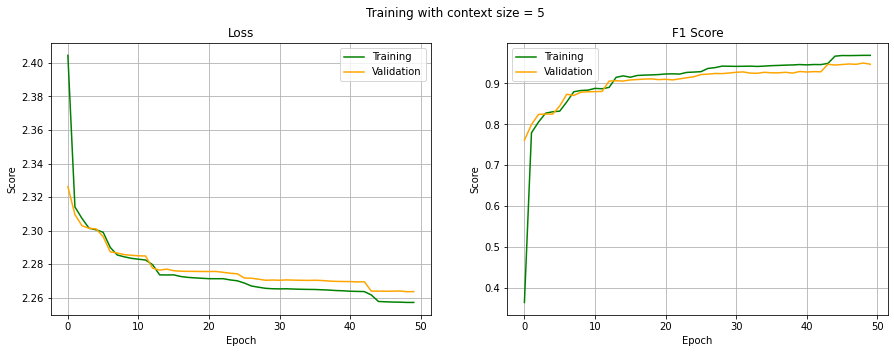

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9686, device='cuda:0'),
 tensor(0.9477, device='cuda:0'),
 tensor(0.9447, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9686, device='cuda:0'),
 tensor(0.9477, device='cuda:0'),
 tensor(0.9447, device='cuda:0'))

## Heatmap

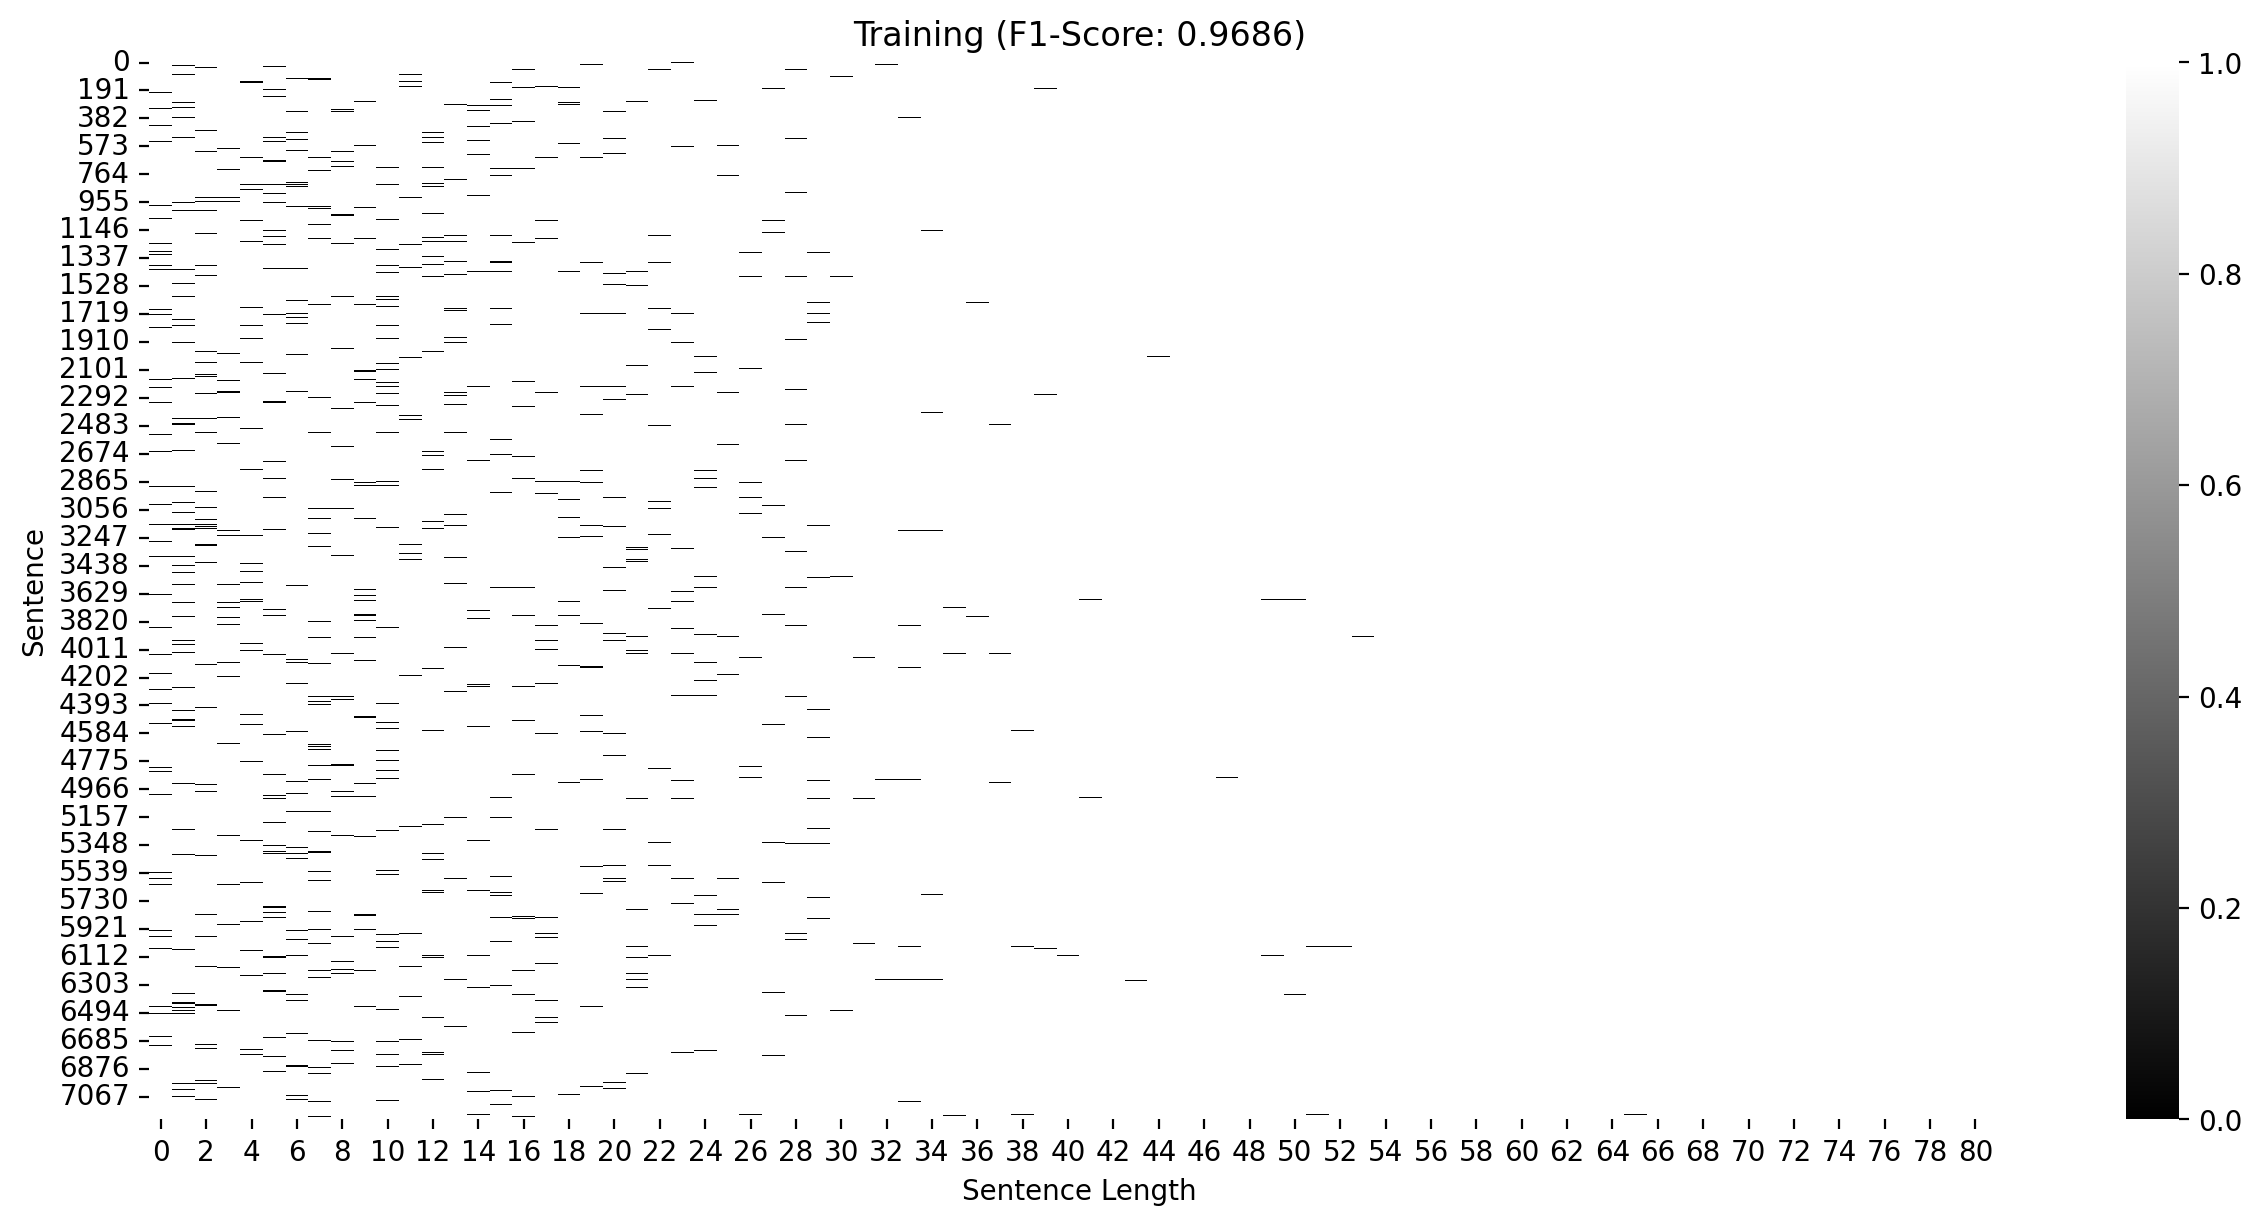

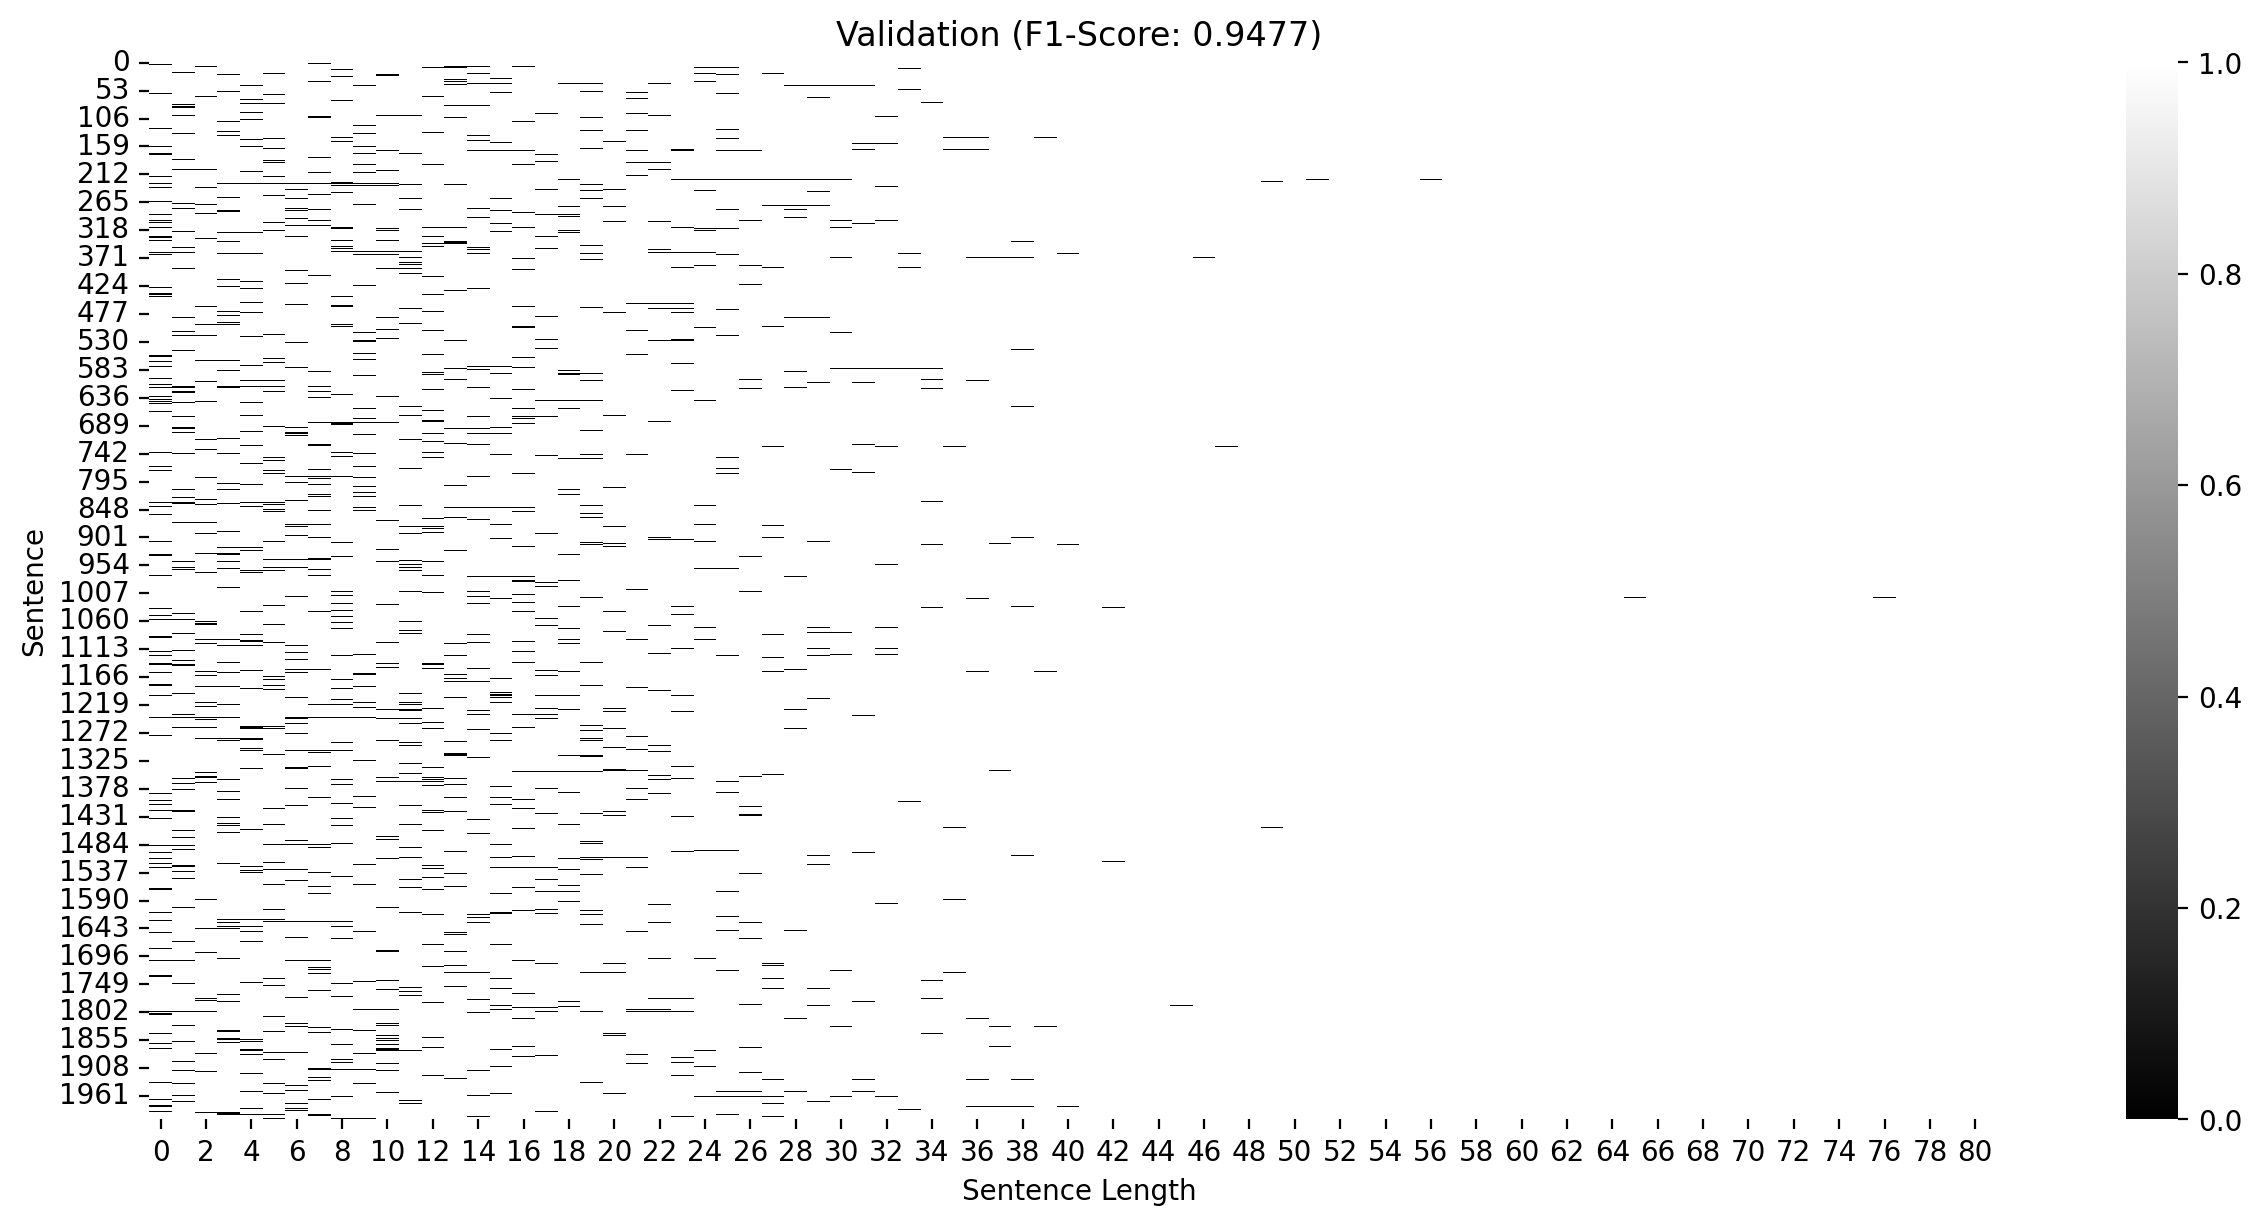

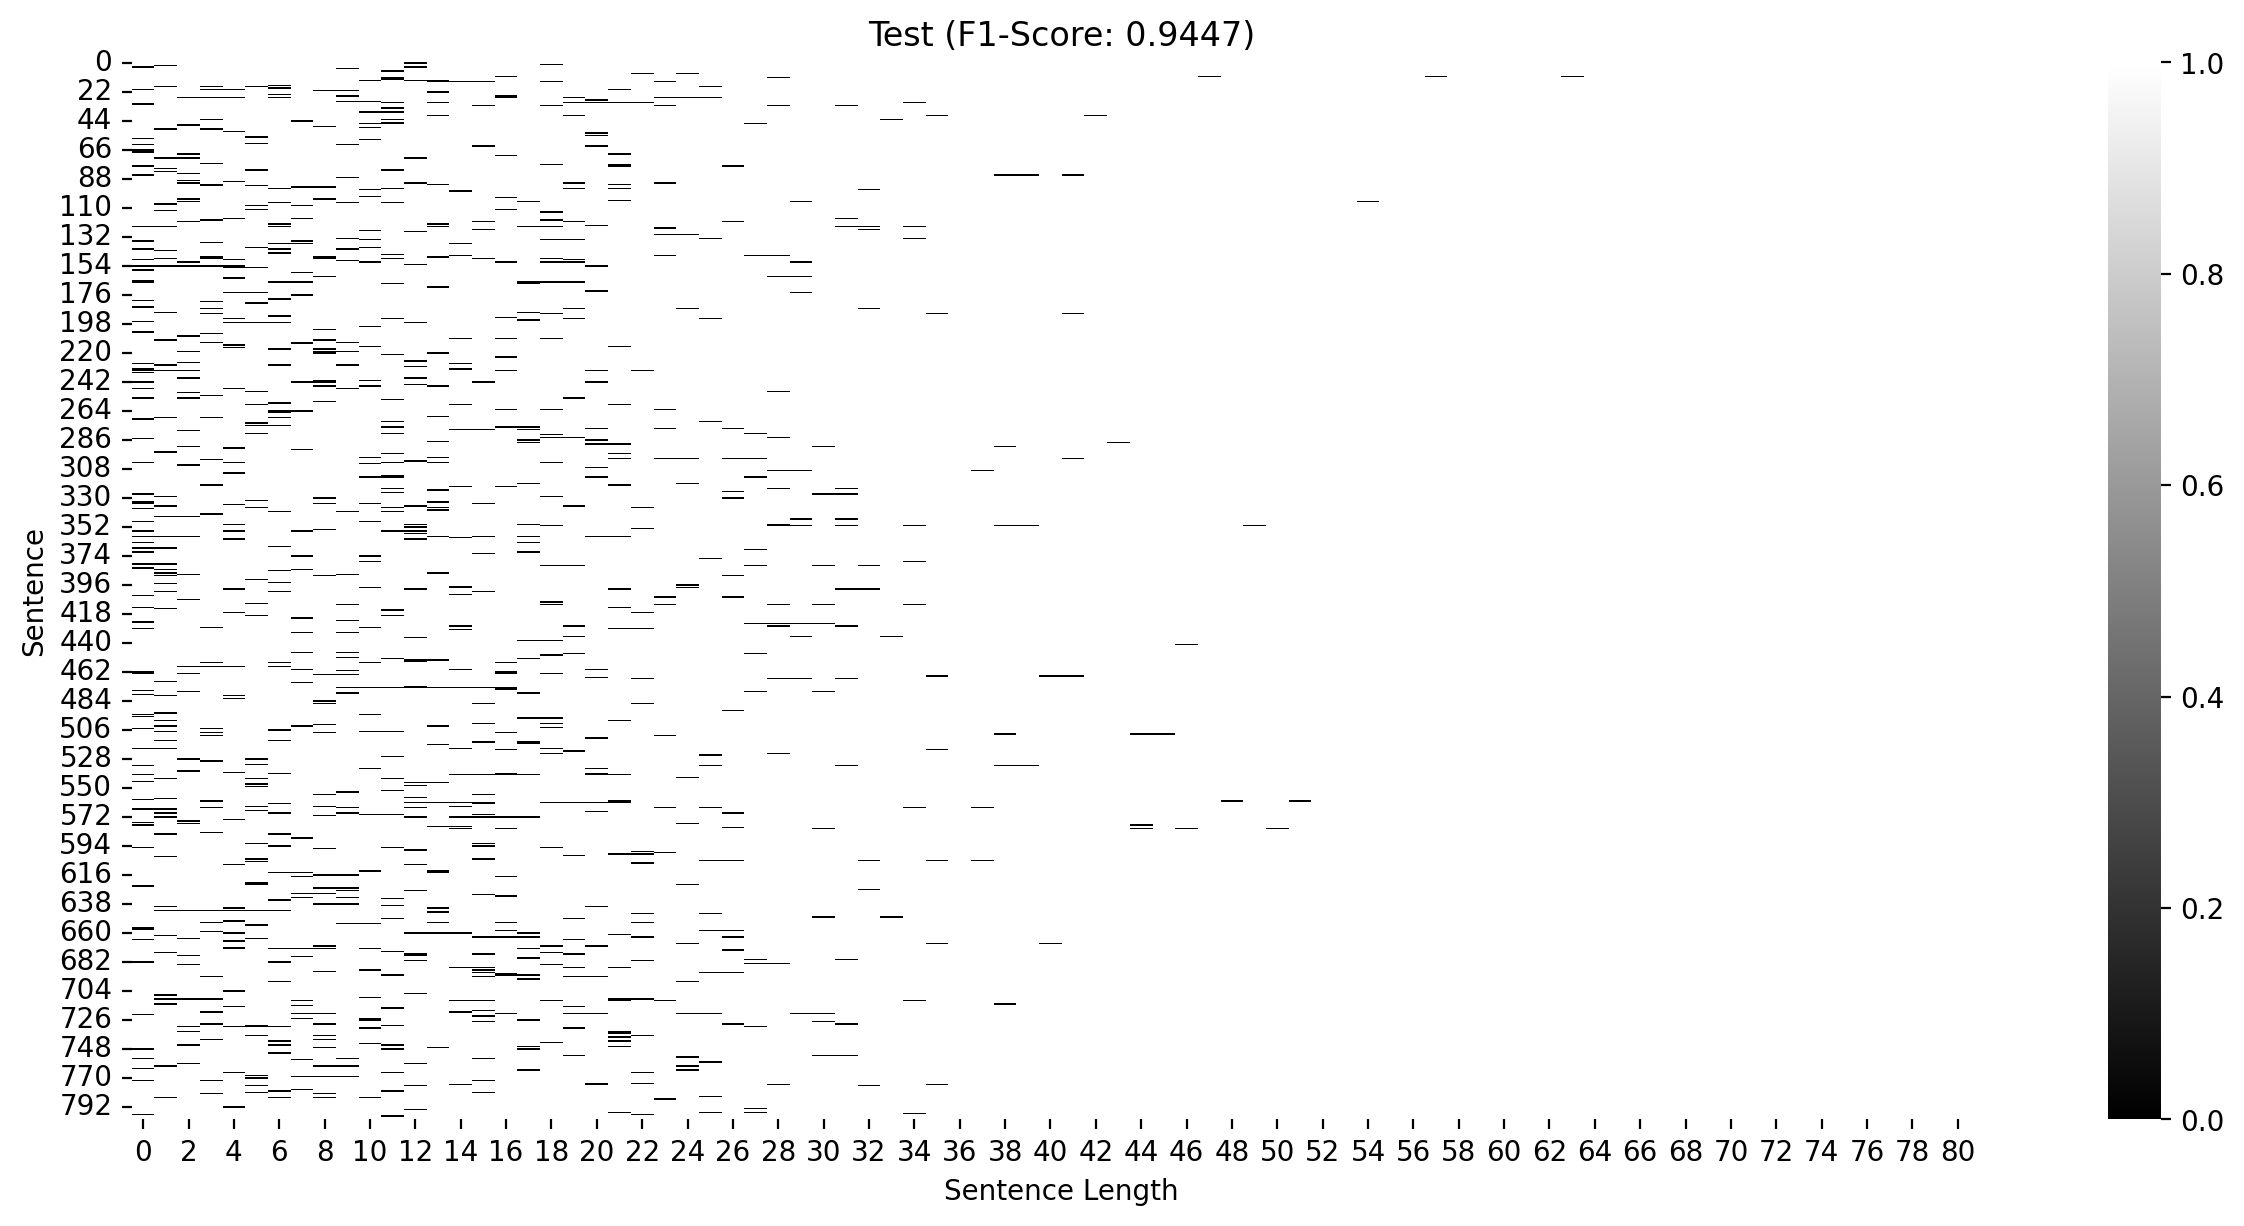

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 168 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


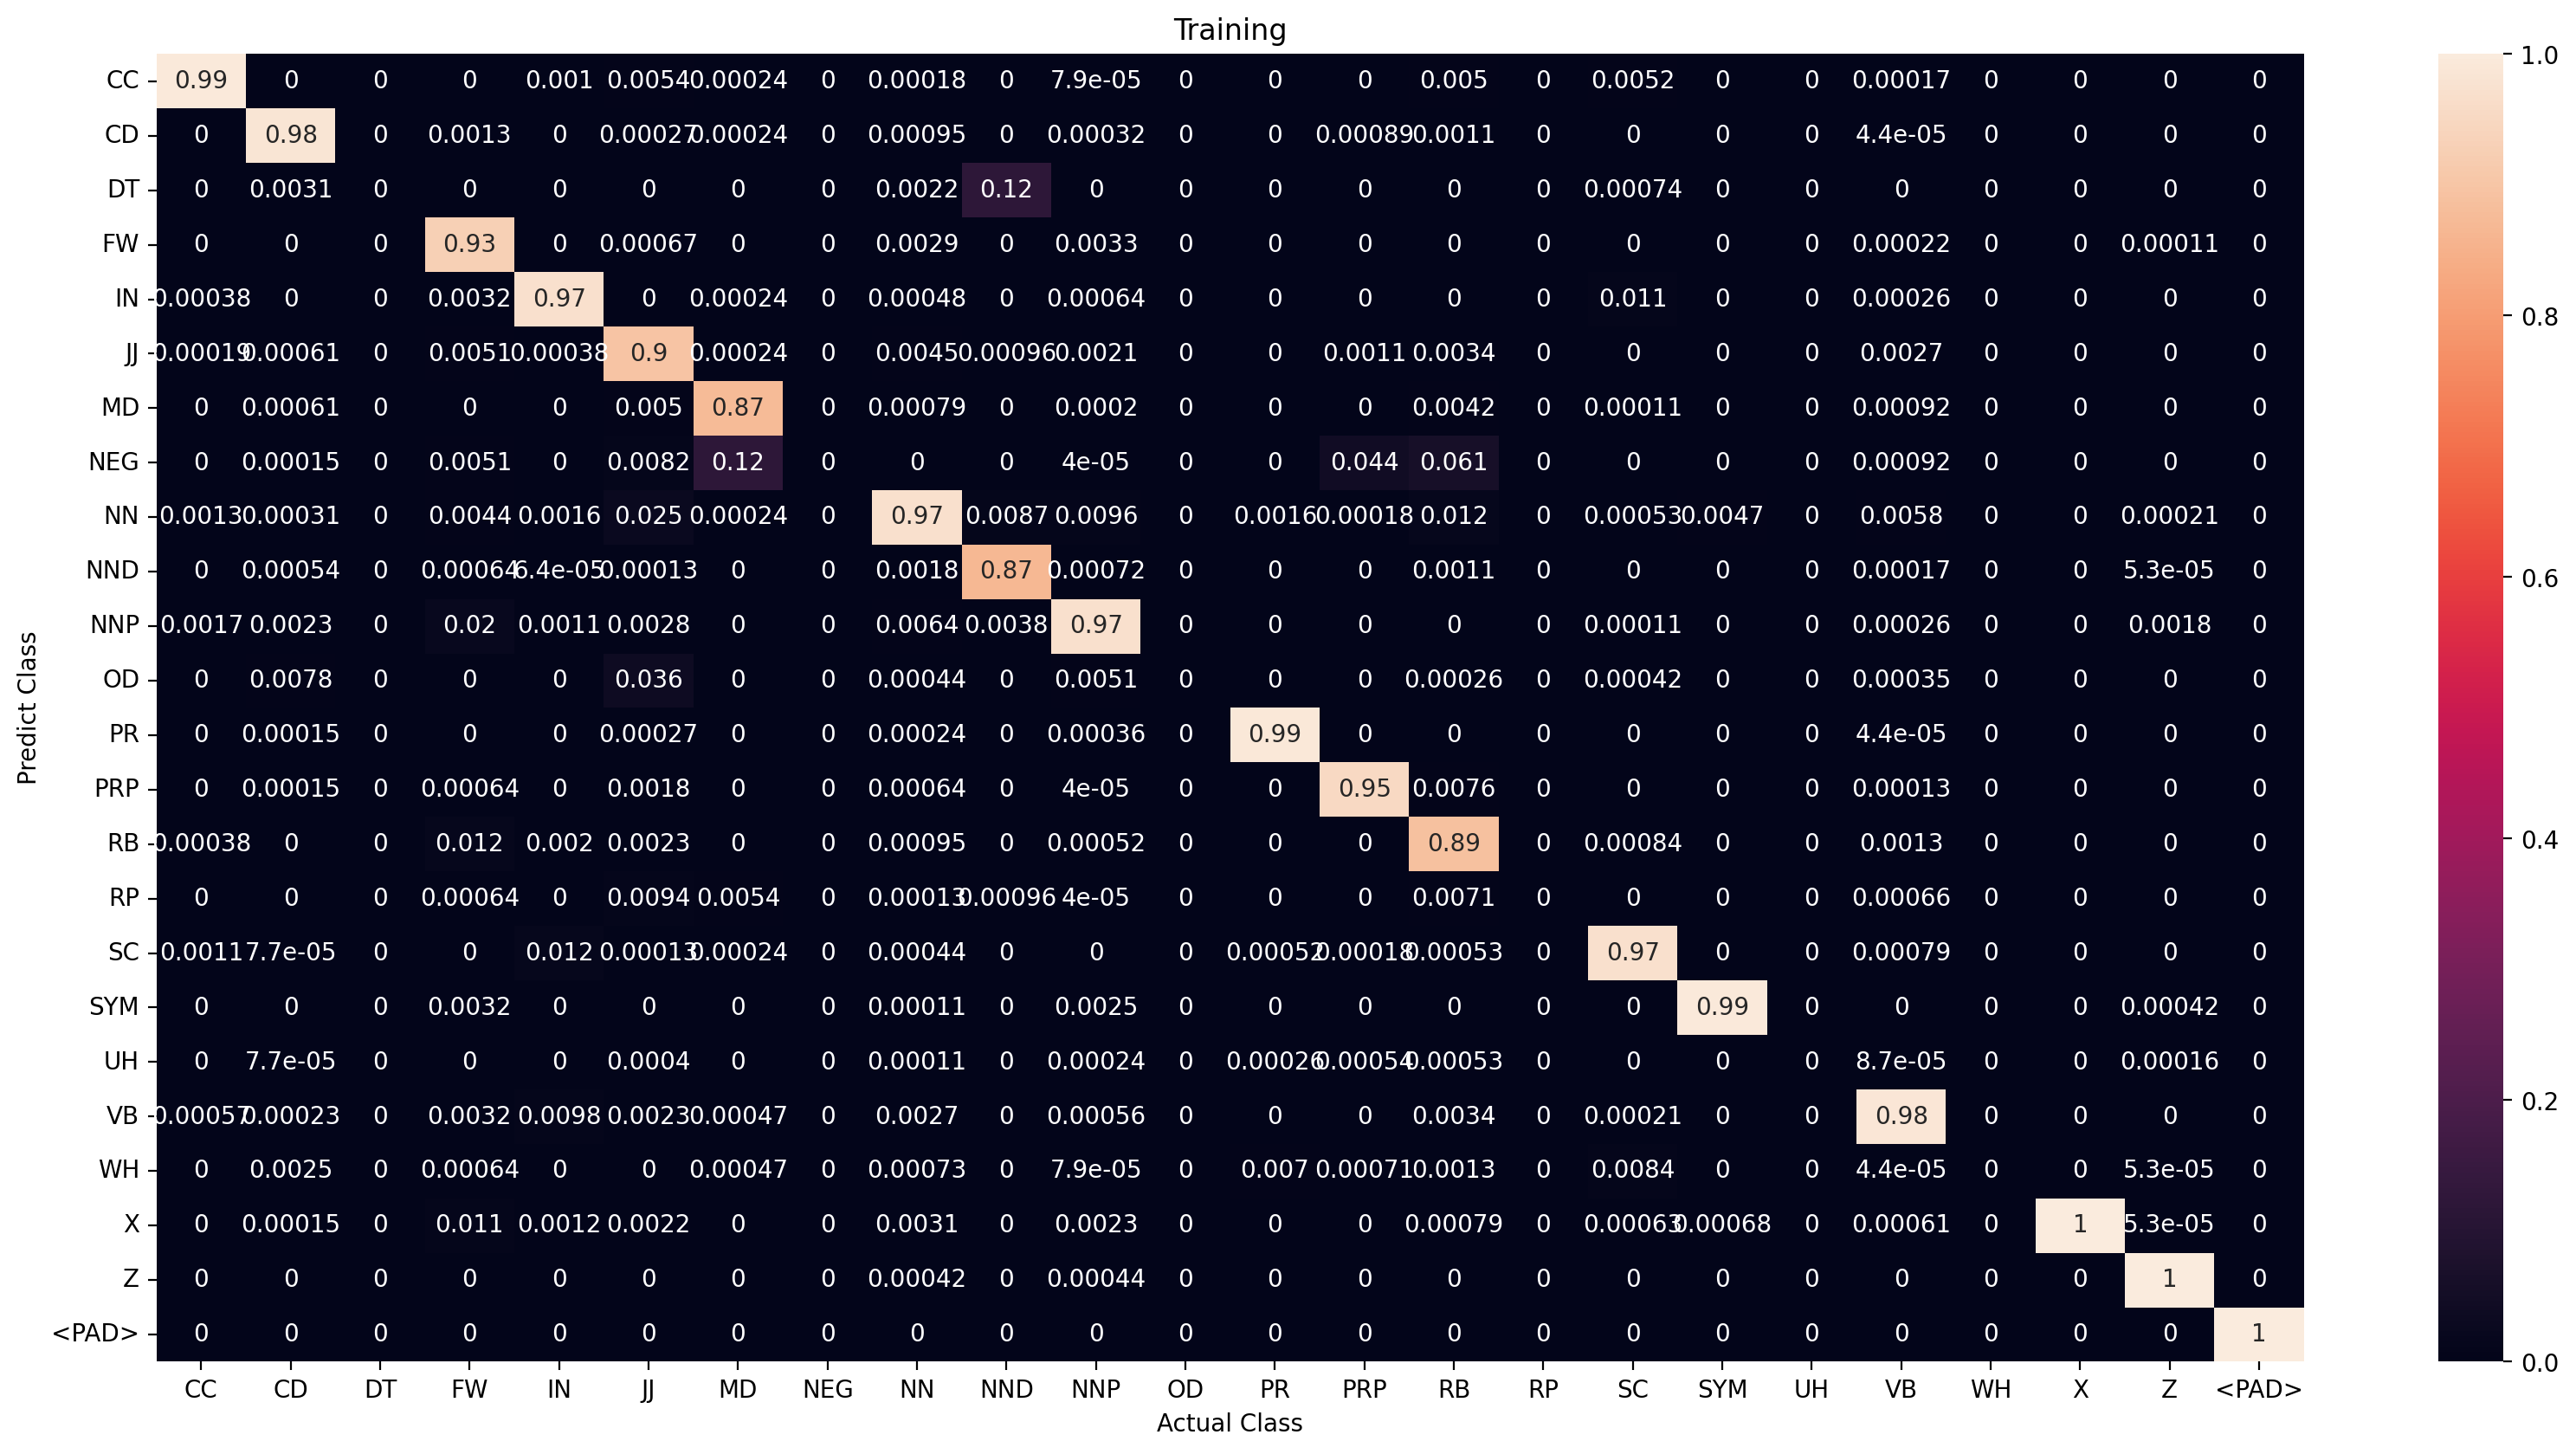

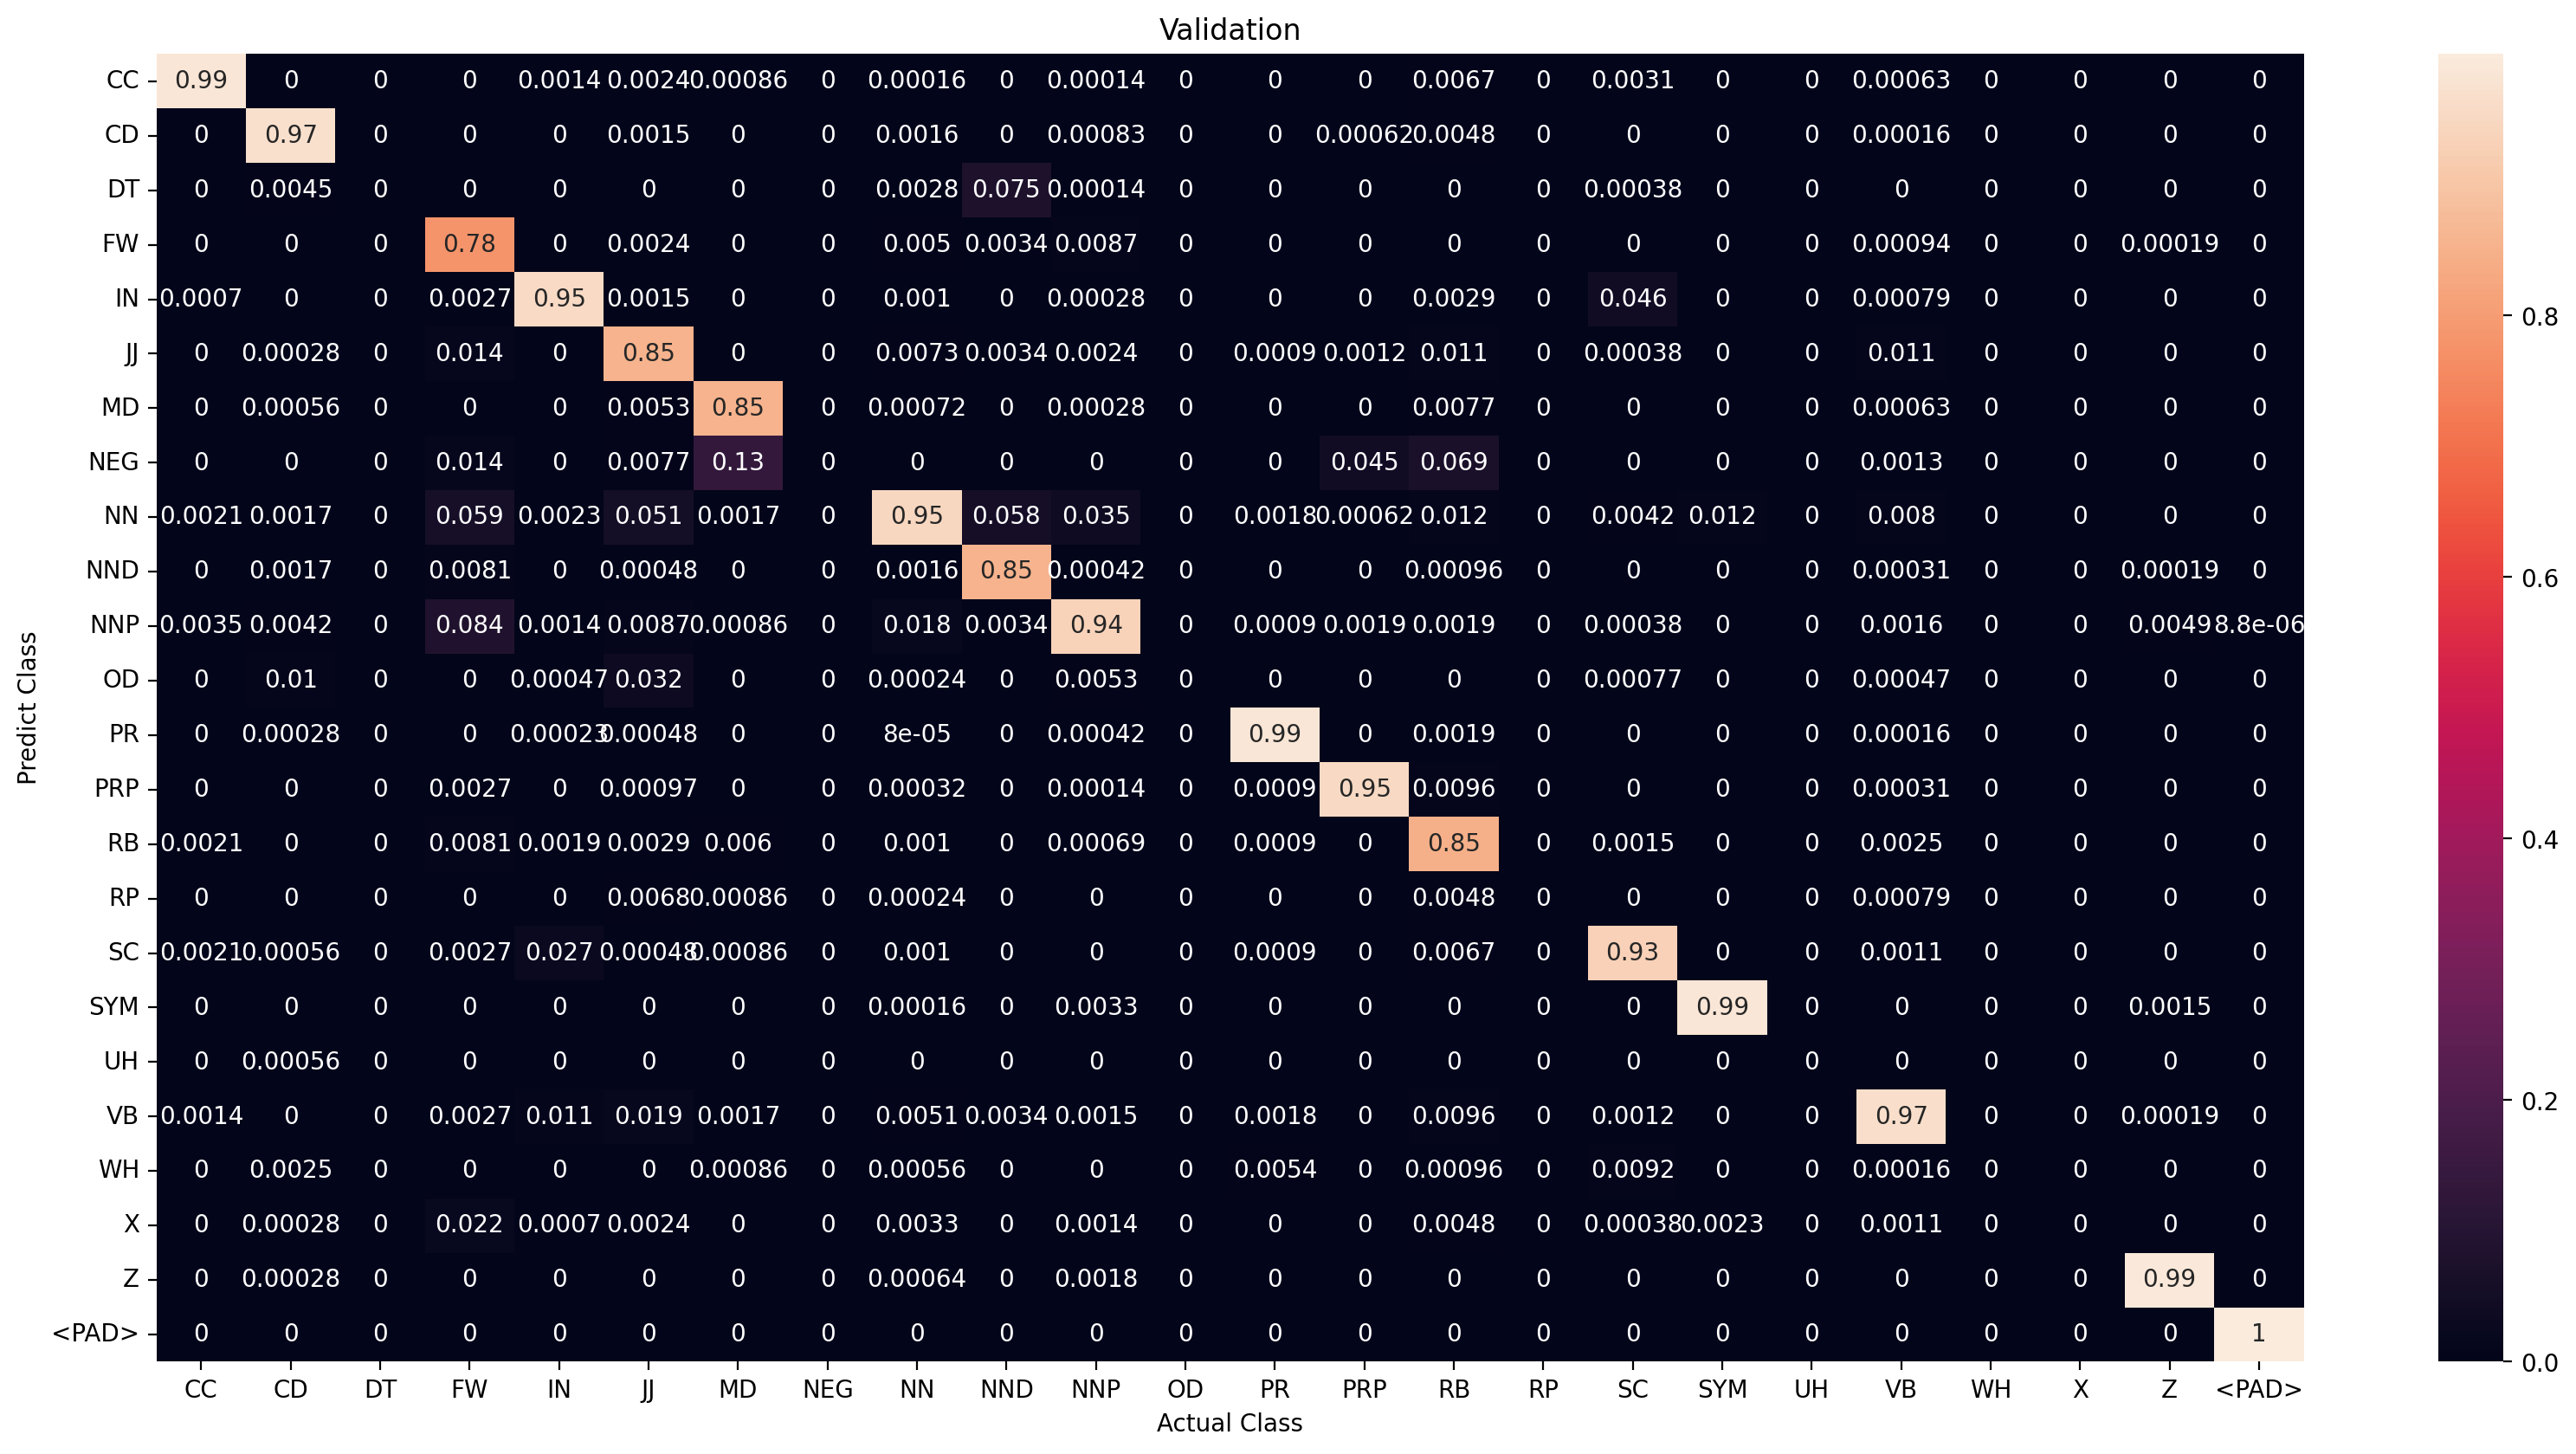

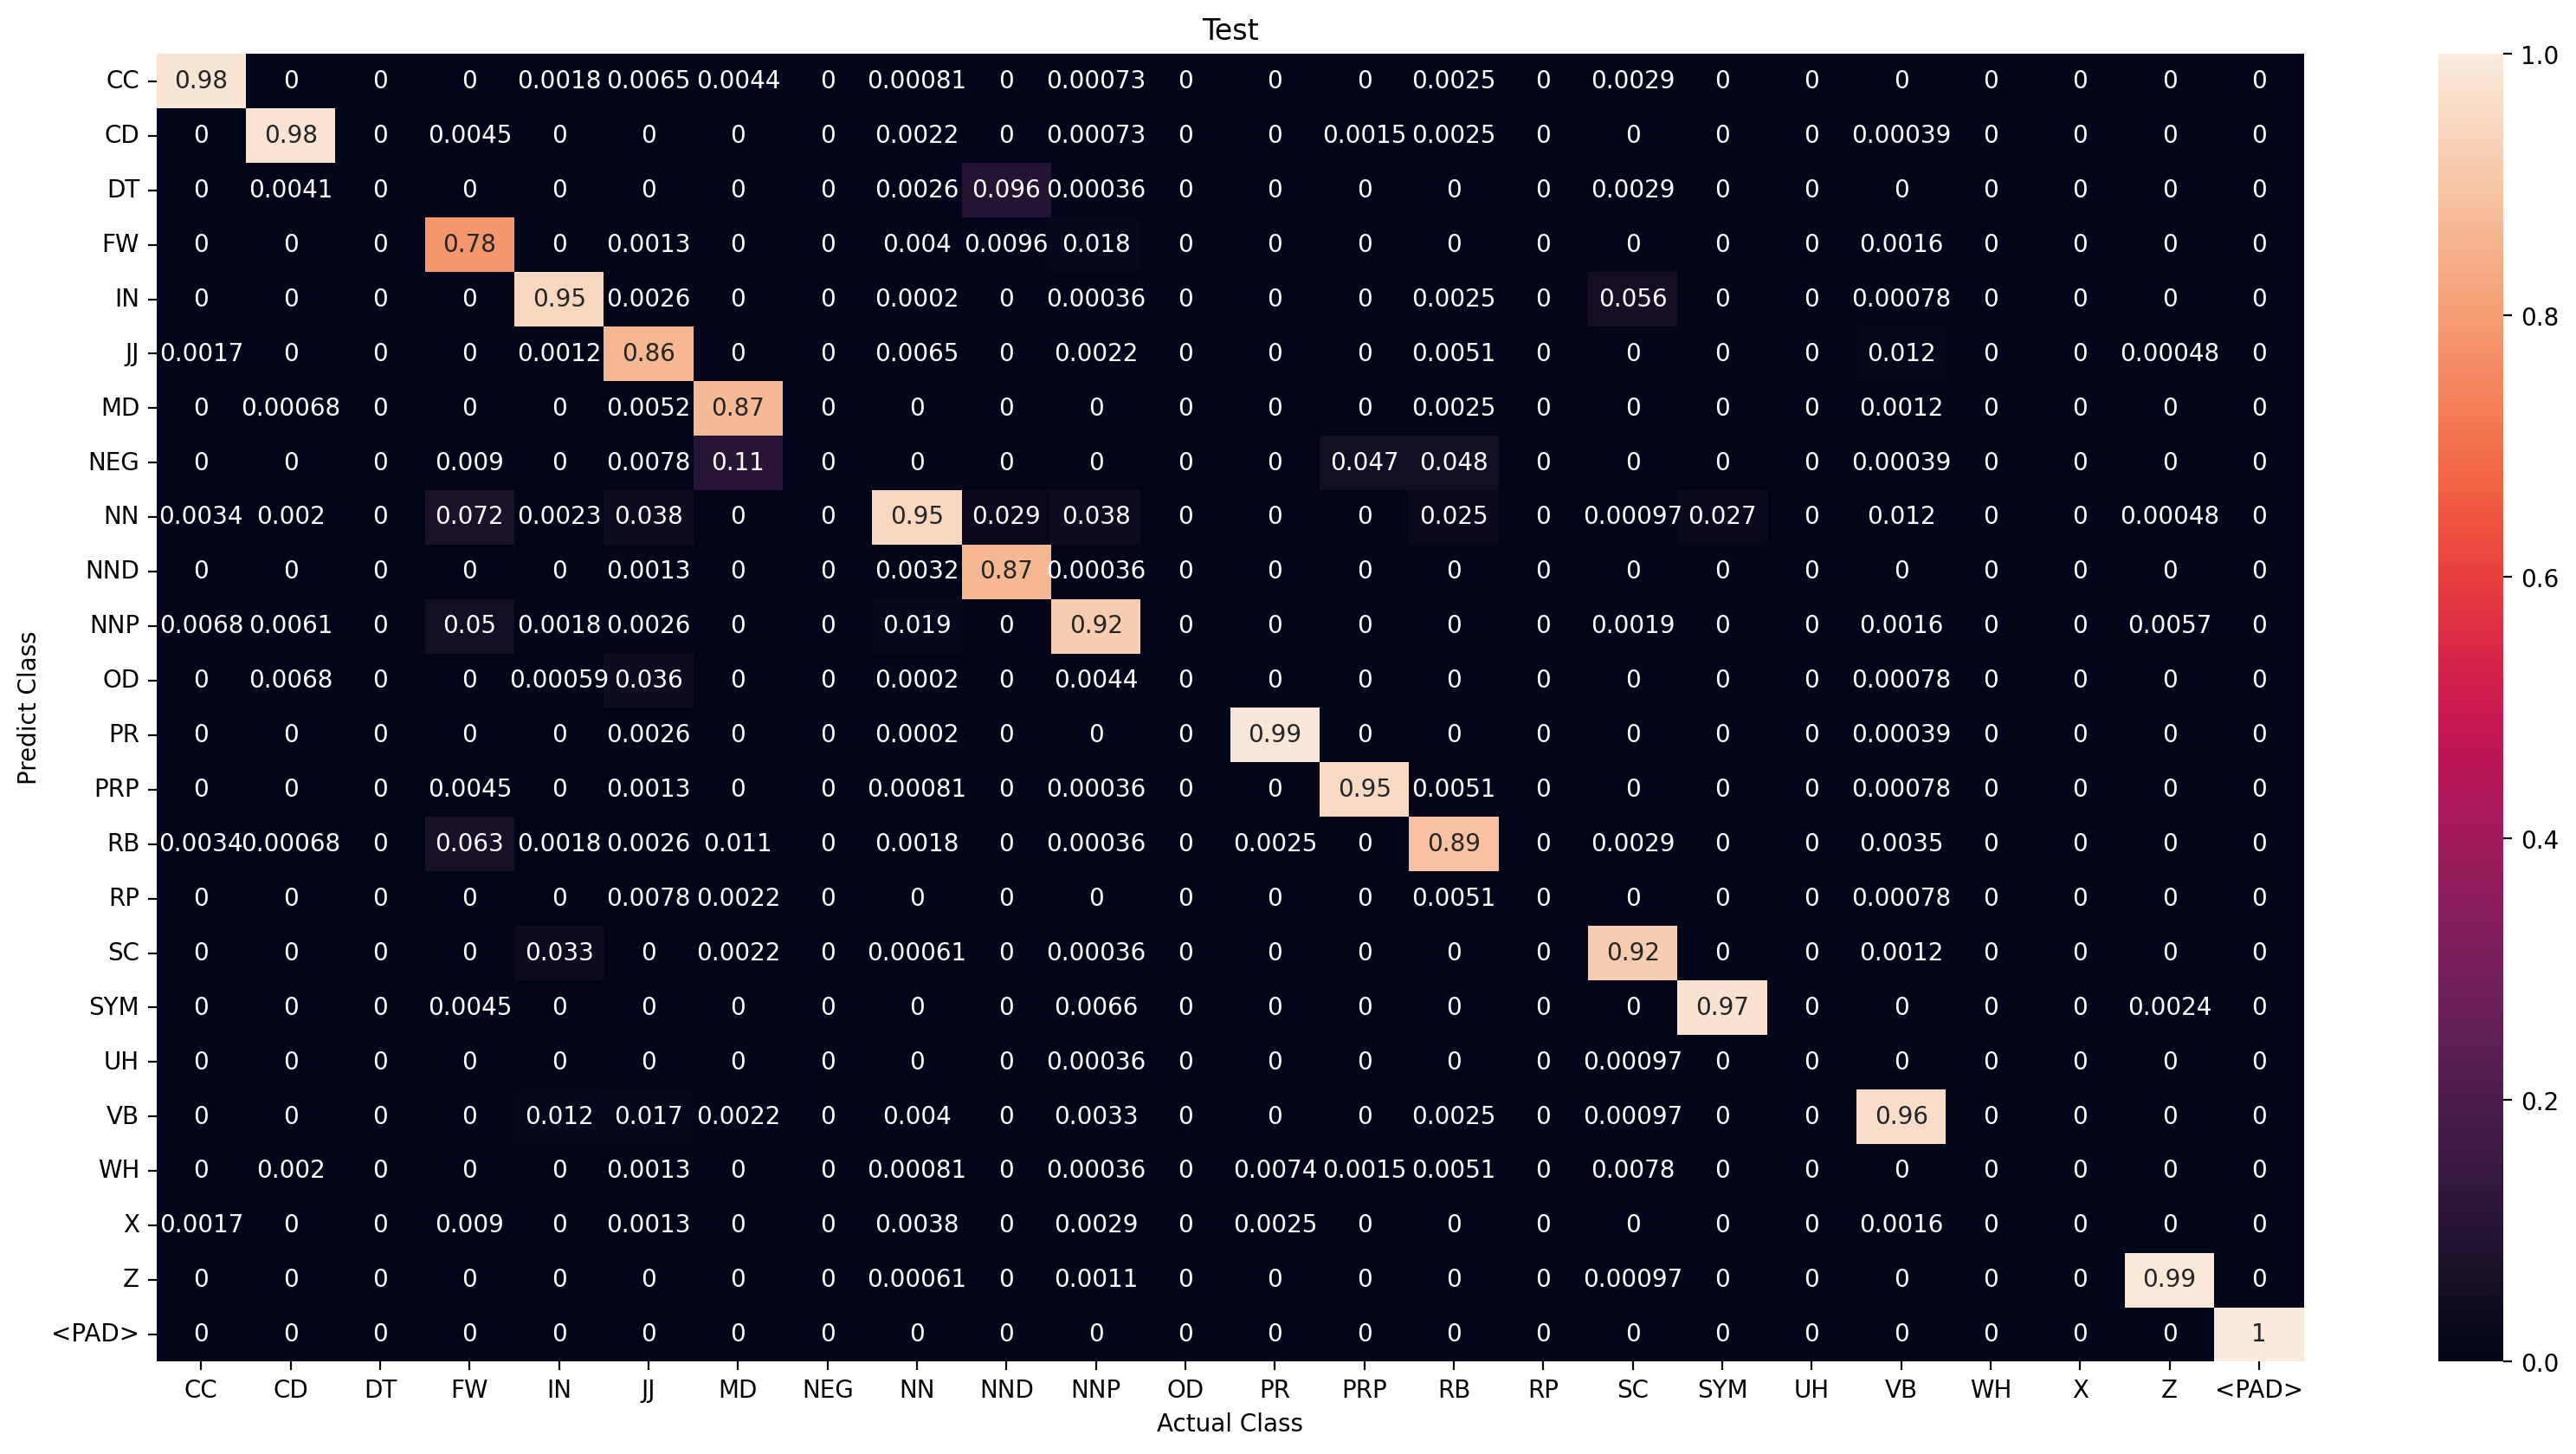

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5252       | CC    : 139      |
| CD    : 12882  | CD    : 12816      | CD    : 66       |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1461       | FW    : 229      |
| IN    : 15403  | IN    : 15248      | IN    : 155      |
| JJ    : 7018   | JJ    : 6654       | JJ    : 364      |
| MD    : 3810   | MD    : 3686       | MD    : 124      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44046      | NN    : 682      |
| NND   : 1019   | NND   : 901        | NND   : 118      |
| NNP   : 24885  | NNP   : 24438      | NNP   : 447      |
| OD    : 534    | OD    : 0          | OD    : 534      |
| PR    : 3842   | PR    : 3817       | PR    : 25       |
| PRP   : 5405   | PRP   : 5327       | PRP   : 78       |
| RB    : 3553   | RB    : 3389       | RB    : 164      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11096
Wrong prediction            : 712
Percentage correct oov pred : 93.97018970189703

Validation
Number OOV token            : 3395
Correct prediction          : 3048
Wrong prediction            : 347
Percentage correct oov pred : 89.77908689248896

Test
Number OOV token            : 1359
Correct prediction          : 1208
Wrong prediction            : 151
Percentage correct oov pred : 88.88888888888889



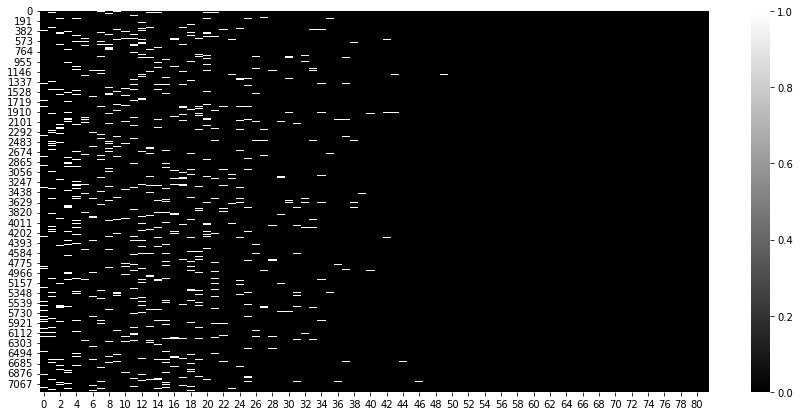

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

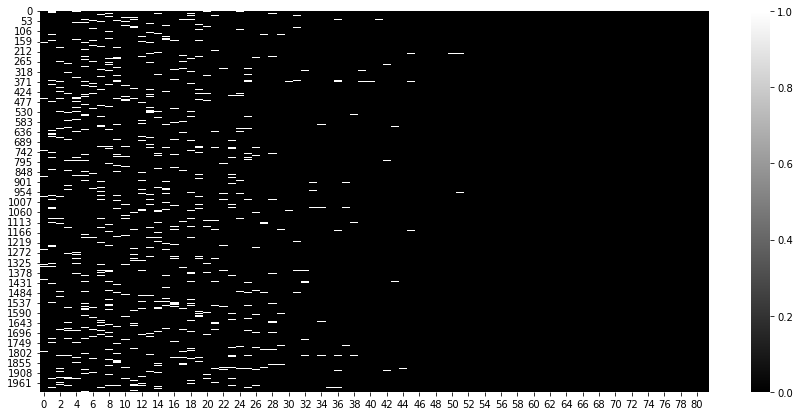

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

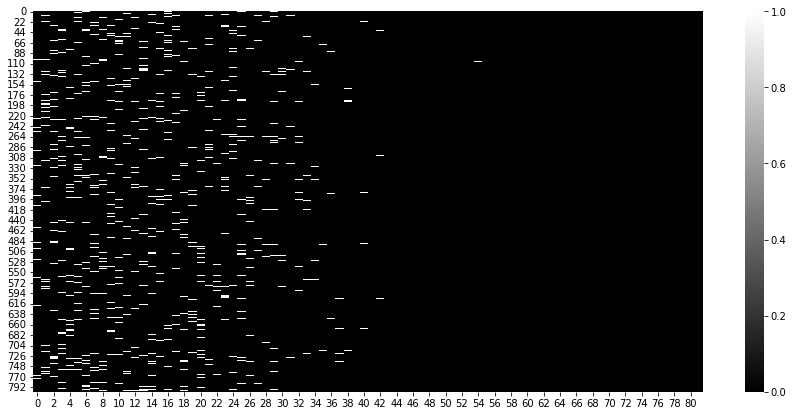

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);